# Proyecto 2

Integrantes:

* André Gibert
* Loudes Mella
* Ailine Morales

**Base de datos elegida**: IMACEC en Chile desde enero del año 2000 hasta mayo del 2023.

IMACEC (Indicador Mensual de Actividad Económica):

* Es un indicador económico que mide la evolución de la actividad económica del país en un período mensual.

* Para calcularlo, se utilizan diversos indicadores de oferta ponderados por la pariticipación de cada actividad económica dentro del PIB del año anterior.

* El valor del IMACEC para un mes se publica el primer día hábil del mes siguiente, y se puede accedder a estos datos a través del Banco Central de Chile.

El objetivo de este proyecto es **crear un modelo de forecast para predecir los valores del IMACEC con el fin de anticipar tendencias económicas en el país**. De ese modo, se contará con una herramienta para la toma de decisiones en el ámbito económico.

## Importamos las librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import kstest, norm, ttest_1samp
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Para series estacionarias
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

## Preprocesamiento

In [5]:
# Cargamos el archivo XLSX en un DataFrame
df = pd.read_excel('Imacec.xlsx', skiprows=1, header=1,names = ["Periodo","Imacec"])
df['Periodo'] = pd.to_datetime(df['Periodo'])
# Establecer la columna 'Periodo' como el índice del DataFrame
df.set_index('Periodo', inplace=True)
df.head()

,Imacec
Periodo,
2000-01-01,49.971312
2000-02-01,47.757649
2000-03-01,52.773356
2000-04-01,51.375397
2000-05-01,51.048322


## Análisis Exploratorio

### Revisando los datos

In [6]:
df.tail()

,Imacec
Periodo,
2023-01-01,104.773280
2023-02-01,99.822361
2023-03-01,113.984748
2023-04-01,107.173114
2023-05-01,108.102630


In [ ]:
df.shape

(281, 1)

* El dataframe contiene 281 filas.

In [ ]:
df.describe()

,Imacec
count,281.000000
mean,80.498434
std,18.578768
min,47.686867
25%,65.113552
50%,82.730095
75%,95.307190
max,121.164307


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2000-01-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Imacec  281 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


* Nuestros datos son del tipo flotante.
* No tenemos datos nulos.

In [ ]:
print("Fecha mínima:", df.index.min())
print("Fecha máxima:", df.index.max())
print("Rango de tiempo:", df.index.max()-df.index.min())

Fecha mínima: 2000-01-01 00:00:00
Fecha máxima: 2023-05-01 00:00:00
Rango de tiempo: 8521 days 00:00:00


* Nuestros datos se mueven desde enero del 2000 a mayo del 2023.

### Visualizaciones

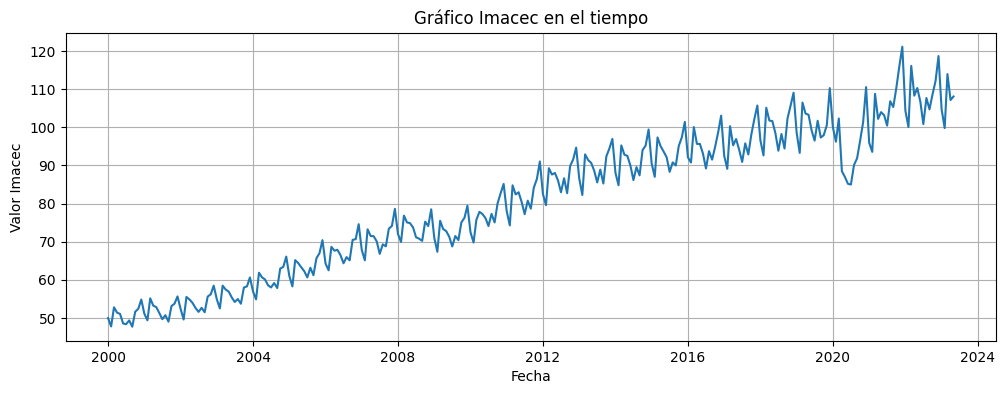

In [ ]:
# Visualización de datos
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Imacec'])
plt.xlabel('Fecha')
plt.ylabel('Valor Imacec')
plt.title('Gráfico Imacec en el tiempo')
# Agrega líneas de cuadrícula
plt.grid(True)
plt.show()

* Vemos que la serie temporal del **IMACEC muestra una clara tendencia lineal al alza**, con una baja considerable alrededor del año 2020. Esto puede deberse a la pandemia del COVID-19 y el impacto que tuvo en la economía mundial.

* Otra baja menos notoria ocurre alrededor del año 2010, la cual puede deberse al efecto de la recesión que tuvo lugar en esos años.

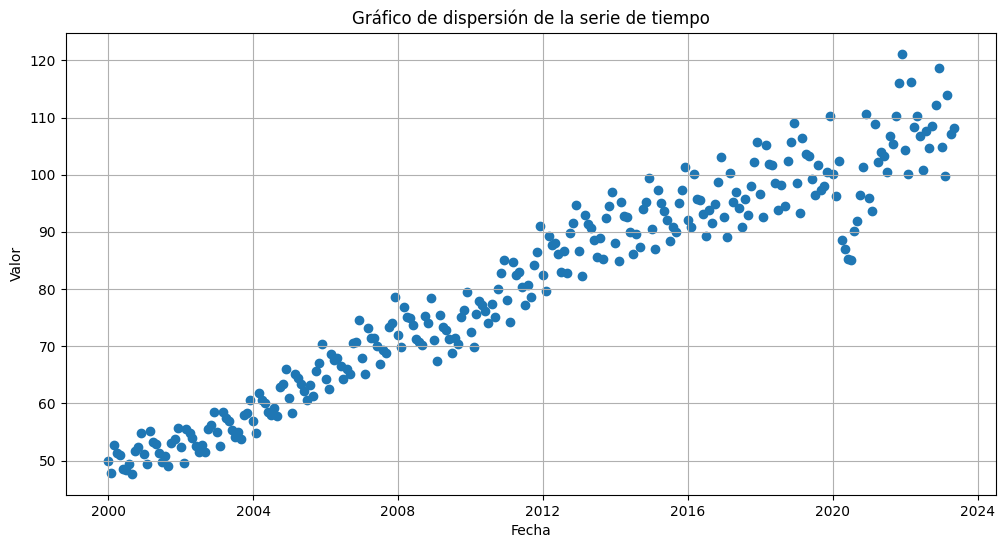

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Imacec'])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de dispersión de la serie de tiempo')
plt.grid(True)
plt.show()

* Logramos visualizar los valores anómalos mencionados anteriormente.

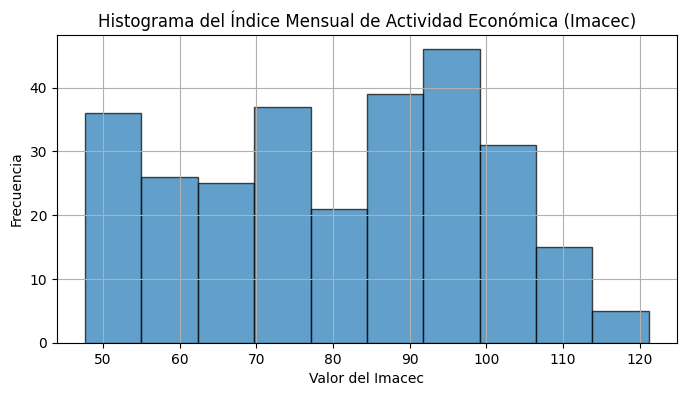

In [ ]:
plt.figure(figsize=(8, 4))

plt.hist(df['Imacec'], bins=10, alpha=0.7, edgecolor='black')

# Agrega líneas de cuadrícula
plt.grid(True)

# Etiquetas y título
plt.xlabel('Valor del Imacec')
plt.ylabel('Frecuencia')
plt.title('Histograma del Índice Mensual de Actividad Económica (Imacec)')

plt.show()

* A simple vista la distribución de los valores de IMACEC no parece ser normal.

#### Variación porcentual

La variación porcentual es una medida que nos permite comprender cómo cambian los valores de una variable con respecto a sus valores anteriores o iniciales en términos de porcentaje.

In [ ]:
df_1 = df.copy()
df_1['variacion_pct'] = df_1['Imacec'].pct_change()*100
df_1['variacion_pct'].fillna(0, inplace=True)
df_1


,Imacec,variacion_pct
Periodo,,
2000-01-01,49.971312,0.000000
2000-02-01,47.757649,-4.429868
2000-03-01,52.773356,10.502417
2000-04-01,51.375397,-2.648987
2000-05-01,51.048322,-0.636637
...,...,...
2023-01-01,104.773280,-11.742184
2023-02-01,99.822361,-4.725363
2023-03-01,113.984748,14.187589


In [ ]:
df_1['variacion_pct'].describe()

count    281.000000
mean       0.436595
std        5.741867
min      -13.846093
25%       -3.274311
50%       -0.800210
75%        4.187686
max       16.278846
Name: variacion_pct, dtype: float64

* **Variabilidad**: La desviación estándar de aproximadamente 5.74 indica que hay una variabilidad considerable en las variaciones porcentuales. Esto sugiere que los valores de la serie de tiempo han experimentado cambios significativos en diferentes momentos.

* **Tendencias**: La media de aproximadamente 0.44 muestra que, en promedio, los valores tienden a cambiar en un pequeño porcentaje positivo o negativo.

* **Valores extremos**: El valor mínimo de -13.85% y el valor máximo de 16.28% indican que ha habido fluctuaciones notables en los datos.

* **Percentiles**: Los percentiles (25%, 50%, 75%) proporcionan información sobre la distribución de las variaciones porcentuales. Por ejemplo, el percentil 25 (-3.27%) indica que el 25% de las variaciones porcentuales son menores o iguales a -3.27%.

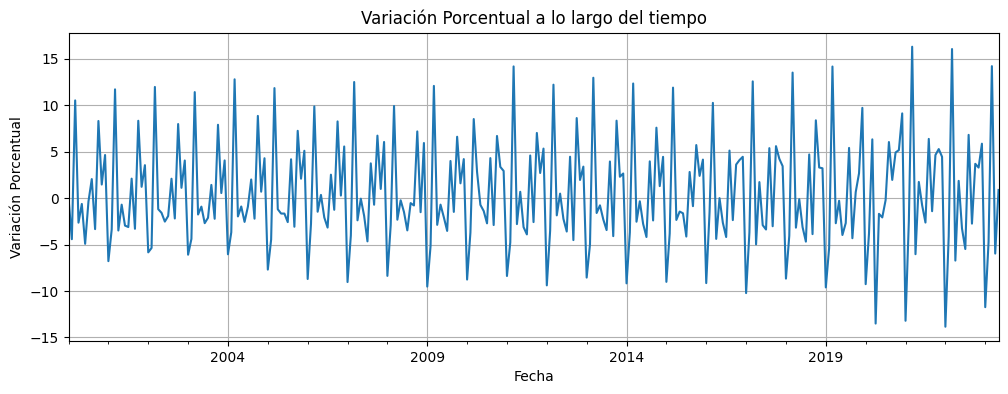

In [ ]:
# Grafico de la variación porcentual a lo largo del tiempo
plt.figure(figsize=(12, 4))
df_1['variacion_pct'].plot()
plt.xlabel('Fecha')
plt.ylabel('Variación Porcentual')
plt.title('Variación Porcentual a lo largo del tiempo')
plt.grid(True)
plt.show()

#### Test de hipótesis

In [ ]:
# Extrae los valores de la columna 'Imacec' para realizar el test
sample = df['Imacec']

# Calcula la media y la desviación estándar de la muestra
sample_mean = sample.mean()
sample_std = sample.std()

* Test de normalidad (K-S)

In [ ]:
# Realiza el test K-S usando la distribución normal
ks_statistic, ks_p_value = kstest(sample, 'norm', args=(sample_mean, sample_std))

# Define el nivel de significancia (alpha)
alpha = 0.05

# Comprueba si el p-valor es menor que alpha para decidir si rechazar o no la hipótesis nula
if ks_p_value < alpha:
    print("La muestra NO sigue una distribución normal (hipótesis nula rechazada).")
else:
    print("La muestra sigue una distribución normal (hipótesis nula no rechazada).")


La muestra NO sigue una distribución normal (hipótesis nula rechazada).


* Test de media 0

In [ ]:
# Realiza el test t de una muestra
t_statistic, t_p_value = ttest_1samp(sample, popmean=0)

# Define el nivel de significancia (alpha)
alpha = 0.05

# Comprueba si el p-valor es menor que alpha para decidir si rechazar o no la hipótesis nula
if t_p_value < alpha:
    print("La media de la muestra NO es igual a cero (hipótesis nula rechazada).")
else:
    print("La media de la muestra es igual a cero (hipótesis nula no rechazada).")


La media de la muestra NO es igual a cero (hipótesis nula rechazada).


* Test de homocedasticidad

In [ ]:
# Añade una columna de valores constantes para el test
x = sm.add_constant(range(len(sample)))

# Realiza el test de Breusch-Pagan
_, p_value, _, _ = het_breuschpagan(sample, x)

# Define el nivel de significancia (alpha)
alpha = 0.05

# Comprueba si el p-valor es menor que alpha para decidir si rechazar o no la hipótesis nula
if p_value < alpha:
    print("Los errores no son homocedásticos (hipótesis nula rechazada).")
else:
    print("Los errores son homocedásticos (hipótesis nula no rechazada).")


Los errores no son homocedásticos (hipótesis nula rechazada).


## Análisis de series temporales

In [ ]:
#Componentes de una serie de tiempo
ete = seasonal_decompose(df, model = 'additive')

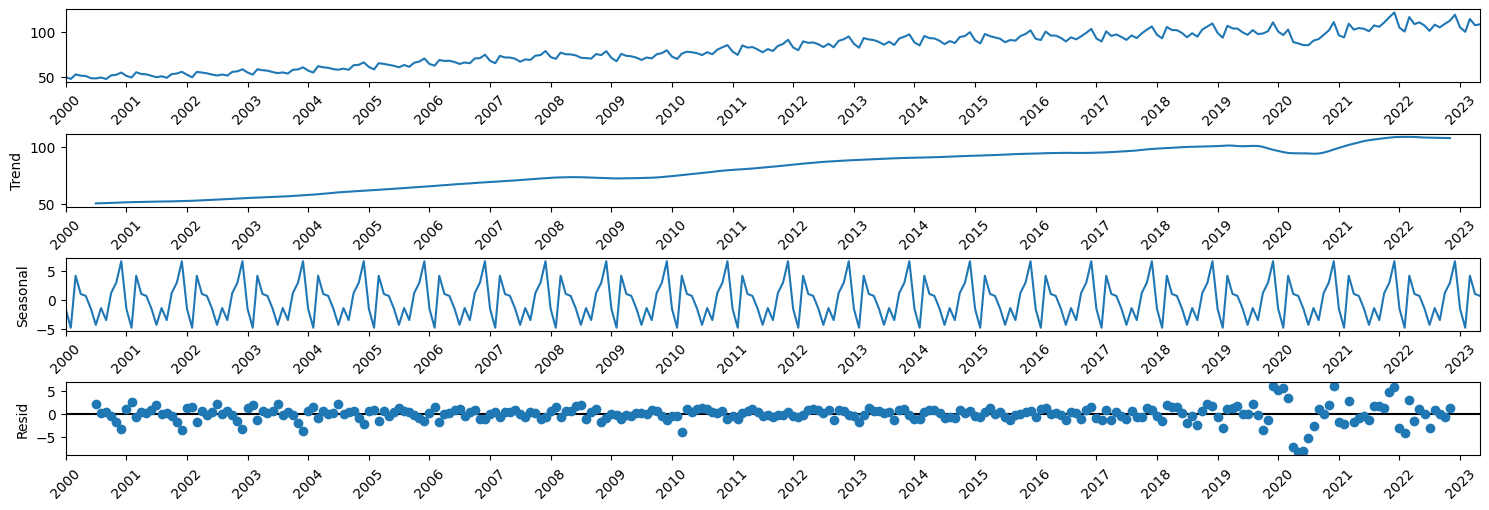

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
graf = ete.plot()
for ax in graf.axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(hspace=0.7)
plt.show()

Nuevamente podemos notar que en el año 2020 ocurren comportamientos anomalos de los datos. Podemos visualizar la abrupta disminución de la tendencia en dicho año, y el aumento de los residuos.

Verificaremos si la serie es estacionaria usando la **prueba Augmented Dickey Fuller**, del paquete statsmodels.adfuller().
La hipótesis nula de la prueba ADF es que la serie de tiempo no es estacionaria. Entonces si el $p-valor$ de la prueba es menor que el nivel de significancia, entonces rechaza la hipótesis nula y se infiere que la serie de tiempo es estacionaria.

In [ ]:
#Test de estacionaridad con un 95% de nivel de confianza

def Augmented_Dickey_Fuller(serie_temporal):
    result = adfuller(serie_temporal)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < 0.05:
        print('Se rechaza la hipótesis nula, por lo tanto la serie temporal es estacionaria con un 0.05 nivel de significancia')
    else:
        print('No hay suficiente evidencia estadística para rechazar la hipótesis nula, por lo tanto la serie temporal no es estacionaria con un 0.05 nivel de significancia')

Augmented_Dickey_Fuller(df)

ADF Statistic: -0.988880
p-value: 0.757298
No hay suficiente evidencia estadística para rechazar la hipótesis nula, por lo tanto la serie temporal no es estacionaria con un 0.05 nivel de significancia


La serie temporal no es estacionaria, lo cual es un resultado esperado dado que la serie presenta una clara tendecia creciente, por lo que no cuenta con media constante.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


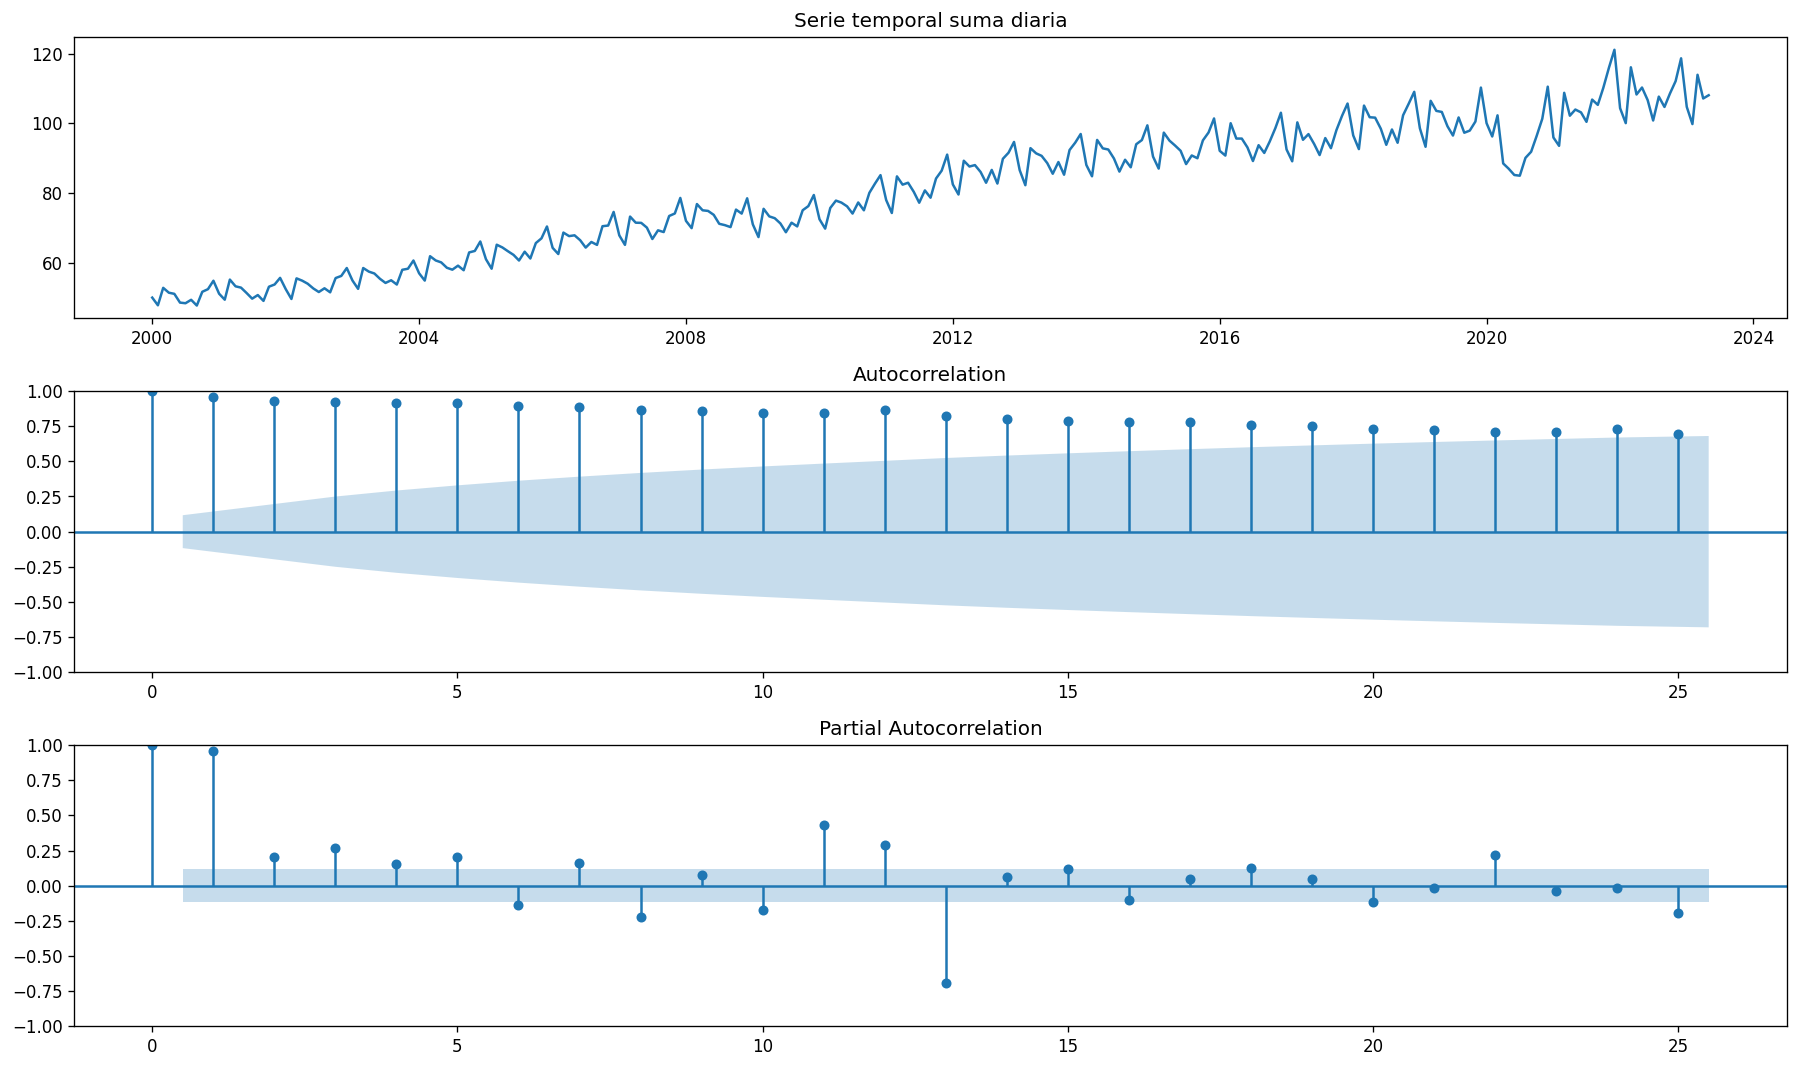

In [ ]:
plt.rcParams.update({'figure.figsize':(15,9), 'figure.dpi':120})

fig, axes = plt.subplots(3,1,sharex = False)
axes[0].plot(df); axes[0].set_title('Serie temporal suma diaria')
plot_acf(df, ax = axes[1])
plot_pacf(df, ax = axes[2])
fig.tight_layout()
plt.show()

## Modelación

El modelo Prophet utiliza una técnica de descomposición para predecir datos de series temporales. Esta técnica descompone la serie temporal en sus componentes de tendencia, estacionalidad y ruido.
* El componente de tendencia es un patrón a largo plazo en los datos, como una tendencia al alza o a la baja.
* El componente de estacionalidad es un patrón a corto plazo que se repite a lo largo del tiempo, como la estacionalidad semanal o mensual.
* El componente de ruido es la variación aleatoria en los datos.

Luego, el modelo Prophet ajusta un modelo a cada uno de los componentes.
* El componente de tendencia se modela utilizando un modelo aditivo o multiplicativo.
* El componente de estacionalidad se modela utilizando una serie de Fourier.
* El componente de ruido se modela utilizando una distribución gaussiana.

Posteriormente, el modelo Prophet usa los modelos ajustados para predecir los valores futuros de la serie temporal. Las predicciones de los componentes de tendencia y estacionalidad se combinan para dar la predicción general de la serie temporal.

In [101]:
# Dividimos nuestros datos en conjuntos de entrenamiento y prueba
df_train = df.loc[:'2022-05']
df_test = df.loc['2021-06':'2023-05']

In [102]:
df_train["ds"] = df_train.index
df_train["y"] = df_train["Imacec"]
df_test["ds"] = df_test.index
df_test["y"] = df_test["Imacec"]

<ipython-input-102-99c41bd6c86d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ds"] = df_train.index
<ipython-input-102-99c41bd6c86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["y"] = df_train["Imacec"]
<ipython-input-102-99c41bd6c86d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt63iy0ey/bpyc33g6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt63iy0ey/ke040zmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43573', 'data', 'file=/tmp/tmpt63iy0ey/bpyc33g6.json', 'init=/tmp/tmpt63iy0ey/ke040zmh.json', 'output', 'file=/tmp/tmpt63iy0ey/prophet_modelvvlknstu/prophet_model-20230803211000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


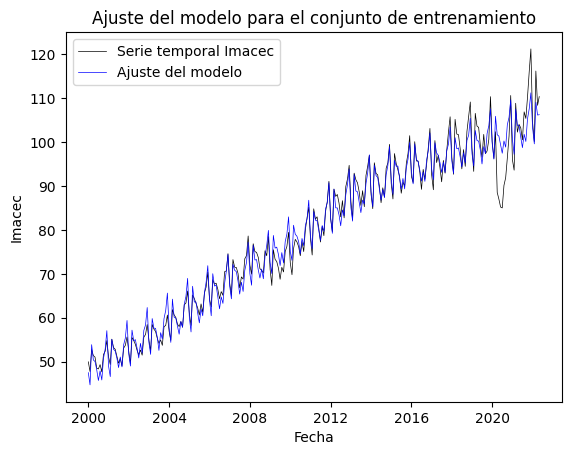

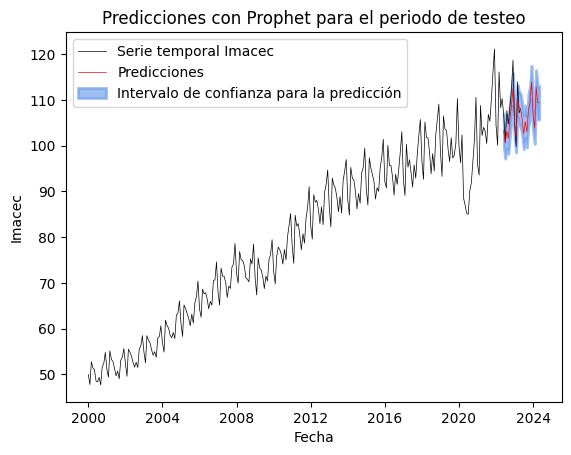

<Figure size 1000x800 with 0 Axes>

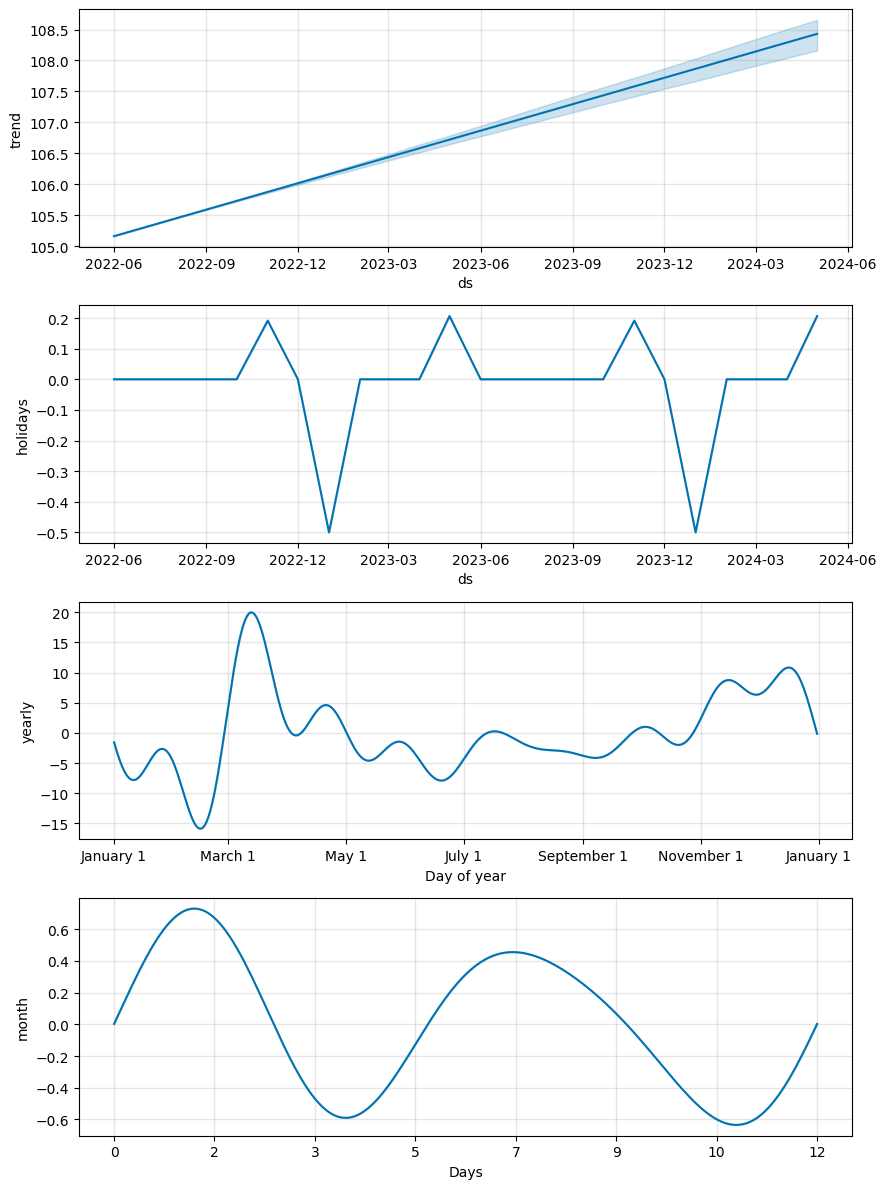

In [132]:
np.random.seed(42)
# Crear modelo prophet
model = Prophet()

# Ajustar la flexibilidad de la tendencia
model.changepoint_prior_scale = 0.05

# Ajustar la estacionalidad
model.add_seasonality(name="month", period=12, fourier_order=3)

# Inlcuir los efectos de los días festivos de Chile
model.add_country_holidays("Chile")

# Entrenar el modelo
model.fit(df_train)

# Ajuste del modelo para los datos de entrenamiento
entrenamiento = model.make_future_dataframe(periods=0, freq="MS")
ajuste= model.predict(entrenamiento)

# Generar los datos futuros
future = model.make_future_dataframe(periods=len(df_test), freq="MS", include_history=False)

# Realizar las predicciones
forecast = model.predict(future)

# Visualizar el ajuste

# Plot df
plt.plot(df_train.index, df_train["y"], label="Serie temporal Imacec", color="black", linewidth=0.5)
# Plot ajuste
plt.plot(ajuste["ds"], ajuste["yhat"], label="Ajuste del modelo", color="blue", linewidth=0.5)
plt.title('Ajuste del modelo para el conjunto de entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Imacec')
plt.legend()
plt.show();


# Visualizar las predicciones

# Plot df
plt.plot(df.index, df["Imacec"], label="Serie temporal Imacec", color="black", linewidth=0.5)
# Plot predicciones
plt.plot(forecast["ds"], forecast["yhat"], label="Predicciones", color="red", linewidth=0.5)
# Agregar intervalo de confianza
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], label="Intervalo de confianza para la predicción",color="cornflowerblue", alpha=0.6, linewidth=2)
plt.title('Predicciones con Prophet para el periodo de testeo')
plt.xlabel('Fecha')
plt.ylabel('Imacec')
plt.legend()
plt.show();



# Plot the components of the model
plt.figure(figsize=(10, 8))
model.plot_components(forecast)
plt.show()

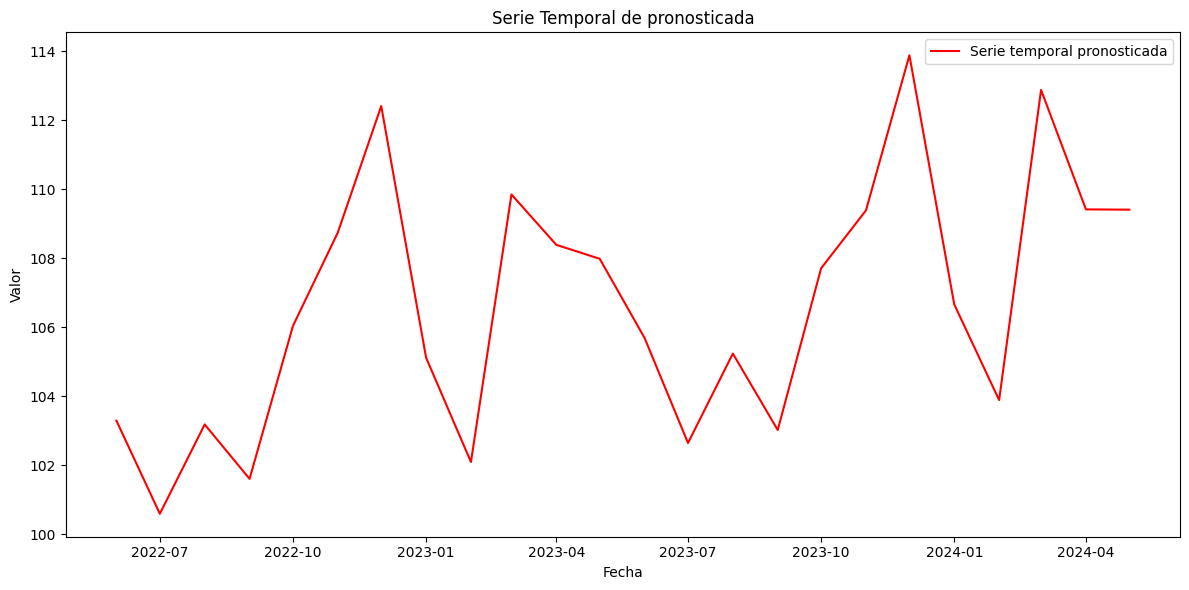

In [134]:
# Crear una figura para graficar la serie temporal de df_test
plt.figure(figsize=(12, 6))

# Graficar la serie temporal de df_test
plt.plot(forecast["ds"], forecast["yhat"], label="Serie temporal pronosticada", color="red")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Serie Temporal de pronosticada")
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

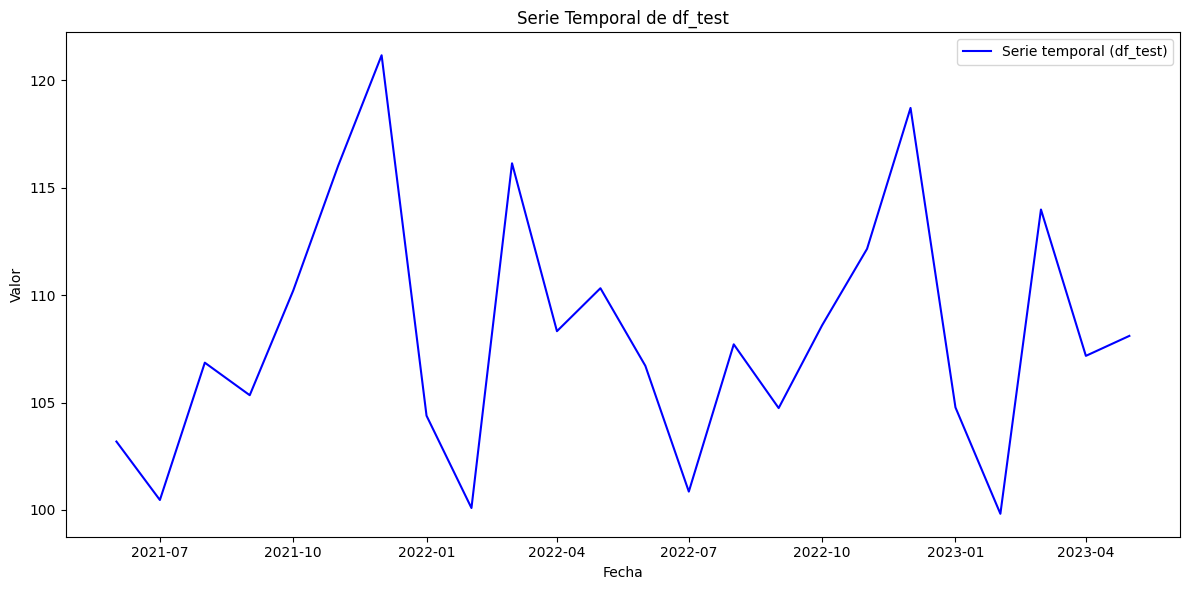

In [135]:
# Crear una figura para graficar la serie temporal de df_test
plt.figure(figsize=(12, 6))

# Graficar la serie temporal de df_test
plt.plot(df_test["ds"], df_test["y"], label="Serie temporal (df_test)", color="blue")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Serie Temporal de df_test")
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

Analizando las predicciones y la serie temporal de df_test, vemos que **el modelo fue capaz de captar la tendencia y la estacionalidad del periodo sobre el cual realizó las predicciones**. Podemos identificar, tanto en los datos de df_test como en las prediciciones una **tendencia al alza**. En cuanto a estacionalidad, notamos que **alrededor del mes de diciembre se ve un alza del valor de IMACEC**, lo cual puede deberse a las temporadas festivas del fin del año y su aporte a la economía.** También se ve un alza del valor del IMACEC alrededor del mes de marzo**, mes en el cual siempre hay mucho movimiento económico por el fin de las vacaciones de verano.

## Métricas de evaluación

In [125]:
rmse_train = mean_squared_error(df_train["y"], ajuste["yhat"], squared=False)
mae_train = mean_absolute_error(df_train["y"], ajuste["yhat"])
rmse_test = mean_squared_error(df_test["y"], forecast["yhat"], squared=False)
mae_test = mean_absolute_error(df_test["y"], forecast["yhat"])

In [126]:
print('El error cuadrático medio para el conjunto de entrenamiento es ' + str(rmse_train))
print('El error absoluto medio para el conjunto de entrenamiento es ' + str(mae_train))
print('El error cuadrático medio para el conjunto de testeo ' + str(rmse_test))
print('El error absoluto medio para el conjunto de testeo es ' + str(mae_test))

El error cuadrático medio para el conjunto de entrenamiento es 2.7779618400203527
El error absoluto medio para el conjunto de entrenamiento es 1.806806854056145
El error cuadrático medio para el conjunto de testeo 3.517948308488212
El error absoluto medio para el conjunto de testeo es 2.7235507305728035


## Busca de los mejores hiperparámetros

In [127]:
#Se define el espacio de busqueda de hiperparametros para el modelo
param_grid = {
    "changepoint_prior_scale": [0.05, 0.1, 0.5],
    "seasonality_prior_scale": [1, 5, 10],
    "holidays_prior_scale": [5, 10],
    "seasonality_mode": ["additive"],
    "fourier_order": [3, 6, 9]
}
# Creamos las variables que estaremos buscando
best_model = None
best_mae = float("inf")

# Bucle para tunear los hiperparámetros
for changepoint_prior_scale in param_grid["changepoint_prior_scale"]:
    for seasonality_prior_scale in param_grid["seasonality_prior_scale"]:
        for holidays_prior_scale in param_grid["holidays_prior_scale"]:
            for seasonality_mode in param_grid["seasonality_mode"]:
                for fourier_order in param_grid["fourier_order"]:

                    # Crear un modelo para probar los hiperparámetros:
                    model = Prophet(
                        changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale,
                        seasonality_mode=seasonality_mode,
                        yearly_seasonality=False,  # If you want to turn off yearly seasonality
                        weekly_seasonality=False,  # If you want to turn off weekly seasonality
                        daily_seasonality=False,  # If you want to turn off daily seasonality
                    )

                    # Ajustar la estacionalidad
                    model.add_seasonality(name="month", period=12, fourier_order=fourier_order)

                    # Inlcuir los efectos de los días festivos de Chile
                    model.add_country_holidays("Chile")  # "CL" is the country code for Chile

                    # Ajustar el modelo a los datos de testeo
                    model.fit(df_train)

                    # Hacer predicciones para el conjunto de testeo
                    future = model.make_future_dataframe(periods=len(df_test))
                    forecast = model.predict(future)

                    # Calcular MAE para el modelo
                    mae = mean_absolute_error(df_test["y"], forecast["yhat"].tail(len(df_test)))

                    # Verificar si el modelo tiene el MAE más bajo
                    if mae < best_mae:
                        best_mae = mae
                        best_model = model

print("Mejores hiperparámetros:")
print("changepoint_prior_scale:", best_model.changepoint_prior_scale)
print("seasonality_prior_scale:", best_model.seasonality_prior_scale)
print("holidays_prior_scale:", best_model.holidays_prior_scale)
print("seasonality_mode:", best_model.seasonality_mode)
print("fourier_order:", best_model.seasonalities["month"]["fourier_order"])
print("Mejor MAE en test:", best_mae)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt63iy0ey/6748de1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt63iy0ey/jpwvaiec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91157', 'data', 'file=/tmp/tmpt63iy0ey/6748de1p.json', 'init=/tmp/tmpt63iy0ey/jpwvaiec.json', 'output', 'file=/tmp/tmpt63iy0ey/prophet_modelaiyzqqkm/prophet_model-20230803210706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt63iy0ey/0xd7wvkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt63iy0ey/hcxsx1wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Mejores hiperparámetros:
changepoint_prior_scale: 0.05
seasonality_prior_scale: 1.0
holidays_prior_scale: 10.0
seasonality_mode: additive
fourier_order: 3
Mejor MAE en test: 4.686540139299457


Como el MAE del modelo inicial en el conjunto de testeo (2.72) es menor que el mejor MAE que encuentra la búsqueda por grilla (4.68), notamos que **los mejores hiperparámetros para el modelo son los utilizados inicialmente, es decir, los hiperparámetros en default**.
En concreto, para este modelo se utilizaron los hiperparámetros *changepoint_prior_scale*=0.05, *seasonality_prior_scale*=10, *holidays_prior_scale*=10 y *seasonality_mode*="additive".
